# Basic UD Part-of-speech Analysis

Fairly basic analysis involving POS tags on some Universal Dependencies corpora

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import conllu

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Read the CoNLL-U file

In [2]:
UD_FILE = "../data/en_partut-ud-train.conllu"

with open(UD_FILE, "r", encoding="utf-8") as data_file:
  data = data_file.read()
  data = conllu.parse(data)

In [3]:
data[:3]

[TokenList<Distribution, of, this, license, does, not, create, an, attorney, -, client, relationship, .>,
 TokenList<Creative, Commons, provides, this, information, on, an, ", as, -, is, ", basis, .>,
 TokenList<Creative, Commons, makes, no, warranties, regarding, the, information, provided, ,, and, disclaims, liability, for, damages, resulting, from, its, use, .>]

## POS counts

In [4]:
pos_counts = defaultdict(int)

for token_list in data:
  for token in token_list:
    pos_tag = token['upostag']
    pos_counts[pos_tag] += 1

<BarContainer object of 18 artists>

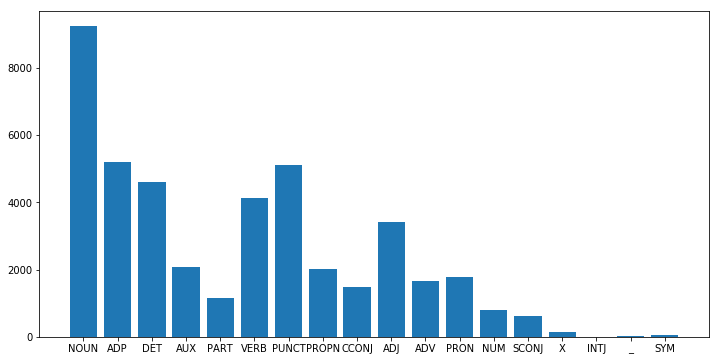

In [5]:
plt.figure(figsize=(12, 6))
plt.bar(pos_counts.keys(), pos_counts.values())

## Gather usages of each lemma

In [6]:
# {lemma -> (POS, word, sentence)}
lemma_forms = defaultdict(list)

for token_list in data:
  sentence = ' '.join([t['form'] for t in token_list])
  for token in token_list:
    pos_tag = token['upostag']
    lemma = token['lemma']
    word = token['form']
    lemma_forms[lemma].append((pos_tag, word, sentence))

## Noun/Verb statistics for each lemma

In [7]:
lemma_count_df = []
for lemma, lemma_occurrences in lemma_forms.items():
  noun_count = len([word for (pos, word, _) in lemma_occurrences if pos == 'NOUN'])
  verb_count = len([word for (pos, word, _) in lemma_occurrences if pos == 'VERB'])
  lemma_count_df.append({'lemma': lemma, 'noun_count': noun_count, 'verb_count': verb_count})
lemma_count_df = pd.DataFrame(lemma_count_df)

In [8]:
# Filter and compute minority count and ratio
lemma_count_df = lemma_count_df[lemma_count_df['noun_count'] + lemma_count_df['verb_count'] > 0]
lemma_count_df['majority_tag'] = np.where(lemma_count_df['noun_count'] >= lemma_count_df['verb_count'], 'NOUN', 'VERB')
lemma_count_df['total_count'] = lemma_count_df[['noun_count', 'verb_count']].sum(axis=1)
lemma_count_df['minority_count'] = lemma_count_df[['noun_count', 'verb_count']].min(axis=1)
lemma_count_df['minority_ratio'] = lemma_count_df['minority_count'] / lemma_count_df['total_count']
lemma_count_df['is_flexible'] = lemma_count_df['minority_ratio'] > 0.05

In [9]:
lemma_count_df.sort_values('total_count', ascending=False).head(20)

,lemma,noun_count,verb_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
37,work,124,20,NOUN,144,20,0.138889,True
234,have,0,116,VERB,116,0,0.000000,False
20,be,0,93,VERB,93,0,0.000000,False
22,make,0,84,VERB,84,0,0.000000,False
36,use,23,48,VERB,71,23,0.323944,True
663,commission,69,1,NOUN,70,1,0.014286,False
48,right,67,0,NOUN,67,0,0.000000,False
257,time,67,0,NOUN,67,0,0.000000,False
96,state,60,6,NOUN,66,6,0.090909,True
1056,play,48,17,NOUN,65,17,0.261538,True


## Distribution of lemmas

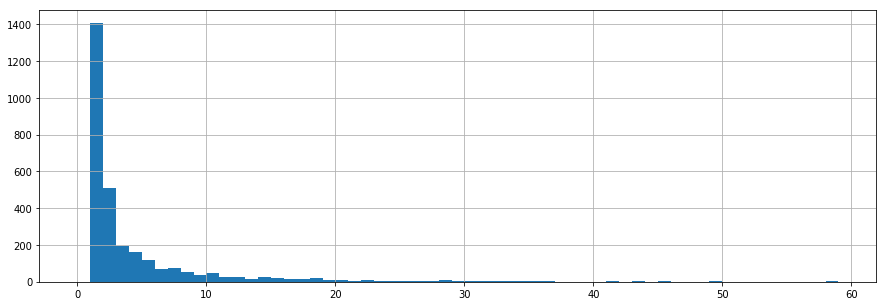

In [10]:
plt.figure(figsize=(15, 5))
lemma_count_df['total_count'].hist(bins=range(0, 60))

## Syntax flexibility metrics

In [11]:
# Only consider lemmas with at least 5 usages
lemma_count_df = lemma_count_df[lemma_count_df['total_count'] >= 5].sort_values('total_count', ascending=False)
noun_lemmas = len(lemma_count_df[lemma_count_df['majority_tag'] == 'NOUN'])
verb_lemmas = len(lemma_count_df[lemma_count_df['majority_tag'] == 'VERB'])
noun_flexibility = len(lemma_count_df[(lemma_count_df['majority_tag'] == 'NOUN') & (lemma_count_df['is_flexible'])]) / noun_lemmas
verb_flexibility = len(lemma_count_df[(lemma_count_df['majority_tag'] == 'VERB') & (lemma_count_df['is_flexible'])]) / verb_lemmas

In [12]:
noun_flexibility

0.19795918367346937

In [13]:
verb_flexibility

0.2488479262672811

In [14]:
# Top flexible nouns
lemma_count_df[(lemma_count_df['majority_tag'] == 'NOUN') & (lemma_count_df['is_flexible'])].head(10)

,lemma,noun_count,verb_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
37,work,124,20,NOUN,144,20,0.138889,True
96,state,60,6,NOUN,66,6,0.090909,True
1056,play,48,17,NOUN,65,17,0.261538,True
439,report,36,4,NOUN,40,4,0.100000,True
55,term,37,2,NOUN,39,2,0.051282,True
790,account,33,5,NOUN,38,5,0.131579,True
814,transport,32,3,NOUN,35,3,0.085714,True
33,result,20,14,NOUN,34,14,0.411765,True
727,issue,30,3,NOUN,33,3,0.090909,True
362,point,20,9,NOUN,29,9,0.310345,True


In [15]:
# Examples of inflexible nouns
lemma_count_df[(lemma_count_df['majority_tag'] == 'NOUN') & (~lemma_count_df['is_flexible'])].head(10)

,lemma,noun_count,verb_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
663,commission,69,1,NOUN,70,1,0.014286,False
257,time,67,0,NOUN,67,0,0.000000,False
48,right,67,0,NOUN,67,0,0.000000,False
354,country,65,0,NOUN,65,0,0.000000,False
334,year,62,0,NOUN,62,0,0.000000,False
322,parliament,61,0,NOUN,61,0,0.000000,False
346,member,58,0,NOUN,58,0,0.000000,False
361,president,58,0,NOUN,58,0,0.000000,False
530,programme,56,0,NOUN,56,0,0.000000,False
372,people,50,1,NOUN,51,1,0.019608,False


In [16]:
# Examples of flexible verbs
lemma_count_df[(lemma_count_df['majority_tag'] == 'VERB') & (lemma_count_df['is_flexible'])].head(10)

,lemma,noun_count,verb_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
36,use,23,48,VERB,71,23,0.323944,True
866,need,14,34,VERB,48,14,0.291667,True
913,support,15,16,VERB,31,15,0.483871,True
451,set,4,25,VERB,29,4,0.137931,True
654,say,2,26,VERB,28,2,0.071429,True
548,increase,7,20,VERB,27,7,0.259259,True
1094,lead,4,23,VERB,27,4,0.148148,True
1520,help,3,19,VERB,22,3,0.136364,True
1858,turn,5,16,VERB,21,5,0.238095,True
782,think,2,17,VERB,19,2,0.105263,True


In [17]:
# Examples of inflexible verbs
lemma_count_df[(lemma_count_df['majority_tag'] == 'VERB') & (~lemma_count_df['is_flexible'])].head(10)

,lemma,noun_count,verb_count,majority_tag,total_count,minority_count,minority_ratio,is_flexible
234,have,0,116,VERB,116,0,0.0,False
20,be,0,93,VERB,93,0,0.0,False
22,make,0,84,VERB,84,0,0.0,False
704,take,0,54,VERB,54,0,0.0,False
328,like,0,53,VERB,53,0,0.0,False
115,include,0,49,VERB,49,0,0.0,False
287,write,0,44,VERB,44,0,0.0,False
4,do,0,43,VERB,43,0,0.0,False
772,give,0,43,VERB,43,0,0.0,False
15,provide,0,35,VERB,35,0,0.0,False
